In [20]:
# import sklearn.neighbors._base
# import sys
# sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

import datetime
from sklearn import metrics, model_selection, ensemble
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import RandomForestClassifier
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.pipeline import make_pipeline
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import TimeSeriesSplit

import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
test = pd.read_csv("./test.csv", delimiter=",", sep='.')
train = pd.read_csv("./train.csv", delimiter=",", sep='.')

In [22]:
pd.set_option('display.max_columns', None)
train.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
0,1,B,B,B,C,B,B,A,E,C,N,0.201470,-0.014822,0.669699,0.136278,0.610706,0.400361,0.160266,0.310921,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850,8.113634
1,2,B,B,A,A,B,D,A,F,A,O,0.743068,0.367411,1.021605,0.365798,0.276853,0.533087,0.558922,0.516294,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083,8.481233
2,3,A,A,A,C,B,D,A,D,A,F,0.742708,0.310383,-0.012673,0.576957,0.285074,0.650609,0.375348,0.902567,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846,8.364351
3,4,B,B,A,C,B,D,A,E,C,K,0.429551,0.620998,0.577942,0.280610,0.284667,0.668980,0.239061,0.732948,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682,8.049253
4,6,A,A,A,C,B,D,A,E,A,N,1.058291,0.367492,-0.052389,0.232407,0.287595,0.686964,0.420667,0.648182,0.684501,0.956692,1.000773,0.776742,0.625849,0.250823,7.972260


# Part 1

In [35]:
import base64

from IPython.core.display import display, HTML
try:
    from facets_overview.generic_feature_statistics_generator import GenericFeatureStatisticsGenerator
except: 
    ! pip install facets-overview
    from facets_overview.generic_feature_statistics_generator import GenericFeatureStatisticsGenerator

In [38]:
gfsg = GenericFeatureStatisticsGenerator()
proto = gfsg.ProtoFromDataFrames([{'name': 'train', 'table': train}])
protostr = base64.b64encode(proto.SerializeToString()).decode("utf-8")

In [39]:
OUTPUT_FILE_PATH = './train.html'

HTML_TEMPLATE = """
        <script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html" >
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""

html = HTML_TEMPLATE.format(protostr=protostr)

# to display
# display(HTML(html))

# to save
with open(OUTPUT_FILE_PATH, "wb") as f:
    f.write(html.encode('utf-8'))

# Part2

array([[<AxesSubplot:title={'center':'target'}>]], dtype=object)

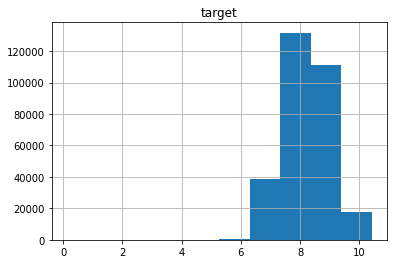

In [11]:
train.hist('target')

In [24]:
num_train = train.select_dtypes([int, float])
cat_train = train.select_dtypes(object)

num = list(num_train.drop(['target'],axis=1))
cat = list(cat_train)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


<AxesSubplot:>

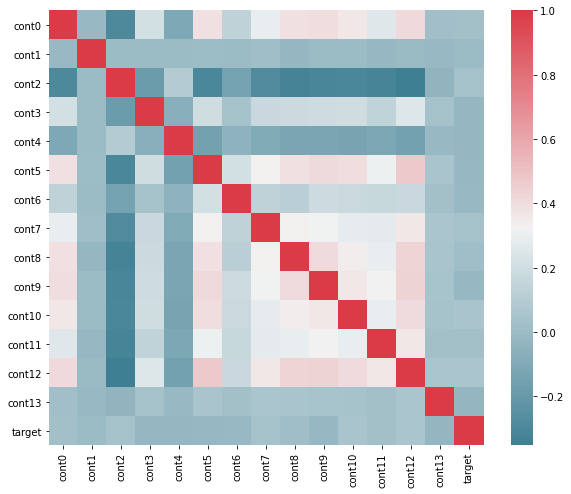

In [25]:
# признаки линейно независимы от таргета, разбить на бины
f, ax = plt.subplots(figsize=(10, 8))
corr = train[num+['target']].corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

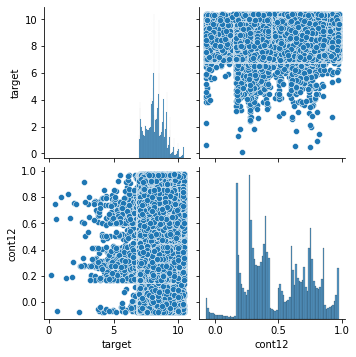

In [66]:
sns.pairplot(train[['target', 'cont12']])

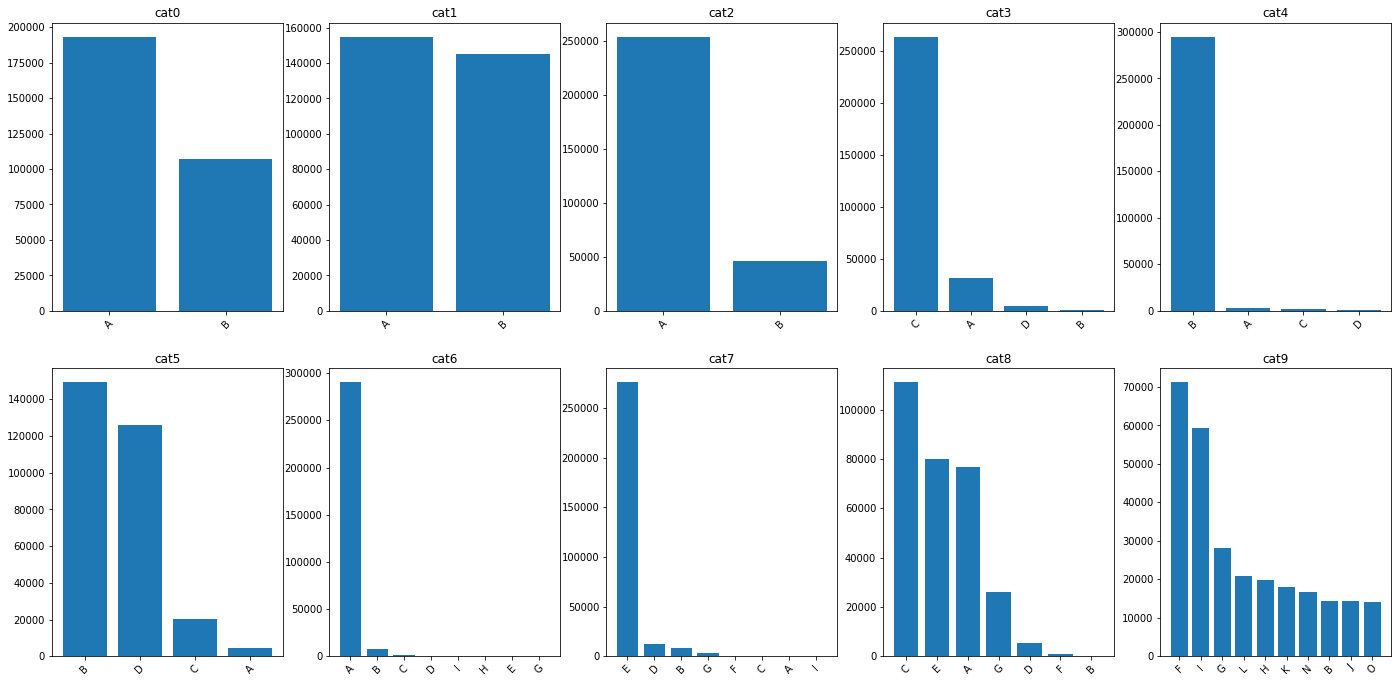

In [18]:
#
plt.figure(figsize = (24, 18))

plot_number = 0
for feature_name in cat:
        plot_number += 1
        plt.subplot(3, 5, plot_number)
        plt.bar(x = train[feature_name].value_counts().nlargest(10).index, 
            height = train[feature_name].value_counts().nlargest(10).values)
        plt.title(feature_name)
        plt.xticks(rotation=45)


In [63]:
def feature_cat3(test):
    if (test.cat3 in ["D", "B"]) or (test.cat4 != "B") or (test.cat6 != "A") or (test.cat7 != "E") or (test.cat8 in ['F', 'B']) :
        return 1 #'Anomaly'
    else:
        return 0 #'Norm'
    
train['anomaly_col'] = train.apply(feature_cat3, axis=1)
test['anomaly_col'] = test.apply(feature_cat3, axis=1)
train

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,anomaly_col
0,0,B,B,B,C,B,B,A,E,E,I,0.296227,0.686757,0.587731,0.392753,0.476739,0.376350,0.337884,0.321832,0.445212,0.290258,0.244476,0.087914,0.301831,0.845702,0
1,5,A,B,A,C,B,C,A,E,C,H,0.543707,0.364761,0.452967,0.929645,0.285509,0.860046,0.798712,0.835961,0.391657,0.288276,0.549568,0.905097,0.850684,0.693940,0
2,15,B,A,A,A,B,B,A,E,D,K,0.408961,0.296129,0.690999,0.740027,0.697272,0.683600,0.404089,0.879379,0.275549,0.427871,0.491667,0.384315,0.376689,0.508099,0
3,16,B,B,A,C,B,D,A,E,A,N,1.031239,0.356062,0.303651,0.895591,0.719306,0.777890,0.730954,0.644315,1.024017,0.391090,0.988340,0.411828,0.393585,0.461372,0
4,17,B,B,A,C,B,C,A,E,C,F,0.530447,0.729004,0.281723,0.444698,0.313032,0.431007,0.390992,0.408874,0.447887,0.390253,0.648932,0.385935,0.370401,0.900412,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,499987,B,A,A,C,B,D,A,E,E,I,0.505445,0.710839,0.225285,0.932926,0.287454,0.543800,0.682378,1.028978,1.022741,0.683903,0.877273,0.532410,0.605397,0.884581,0
199996,499990,B,A,A,C,B,B,A,E,C,F,0.350751,0.887132,0.346864,0.284264,0.794881,0.432778,0.389775,0.359871,0.550013,0.492082,0.202295,0.416875,0.406205,0.758665,0
199997,499991,A,B,B,C,B,B,A,E,C,I,0.378393,0.549489,0.411319,0.437275,0.514487,0.060997,0.171741,0.317185,0.150340,0.122109,0.390524,0.334026,0.378987,0.839416,0
199998,499994,A,A,A,C,B,D,A,D,A,F,1.014149,0.430139,0.067896,0.393523,0.286144,1.061710,0.819811,0.901241,0.555339,0.844315,0.894193,0.794102,0.844279,0.890473,1


In [59]:
train.to_csv('train_anomaly.csv', index=False)
test.to_csv('test_anomaly.csv', index=False)